In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [0]:
NDVI = pd.read_excel("./Used Datasets/NDvi2011-2020.xlsx", infer_datetime_formate=True)
PET = pd.read_excel("./Used Datasets/pet_2010_2020_Scale0.1.xlsx", infer_datetime_format=True)
SolRad = pd.read_excel("./Used Datasets/Srad2010-20.xlsx")
AET = pd.read_excel("./Used Datasets/aet_2010_2020_Scale0.1.xlsx")
Tmin = pd.read_excel("./Used Datasets/tmin.xlsx")
Tmax = pd.read_excel("./Used Datasets/tmax.xlsx")
co2 = pd.read_csv("./Used Datasets/co2_trend_gl_re.txt", delim_whitespace=True)

In [0]:
PAR = np.array(SolRad.values[8 :, 1], dtype=int)*0.1*0.47
NdviArray = np.array(NDVI.values[: -10, 1], dtype=float)
Tavg = (np.array(Tmin.values[8 :, 1], dtype=float) + np.array(Tmax.values[8 :, 1], dtype=float))/20
CO2 = co2.values[:, 3]
W = 0.5 + (np.array(AET.values[17 :,1], dtype=int)/np.array(PET.values[17 :, 1], dtype=int))

In [0]:
W_new = np.zeros(W.size*2, dtype=float)
Tavg_new = np.zeros(Tavg.size*2, dtype=float)
PAR_new = np.zeros(PAR.size*2, dtype=float)
for i in range(Tavg.size):
    W_new[2*i] = W[i]
    Tavg_new[2*i] = Tavg[i]
    PAR_new[i*2] = PAR[i]
    if 2*(i+1)<Tavg_new.size:
        Tavg_new[2*i+1] = (Tavg[i]+Tavg[i+1])/2
        W_new[2*i+1] = (W[i]+W[i+1])/2
        PAR_new[2*i+1] = (PAR[i]+PAR[i+1])/2
Tavg_new[-1] = (Tavg_new[-24]+Tavg_new[-48])/2
W_new[-1] = (W_new[-24]+W_new[-48])/2
PAR_new[-1] = (PAR_new[-24]+PAR_new[-48])/2

W_new = np.zeros(W.size*2, dtype=float)
Tavg_new=np.zeros(Tavg.size*2, dtype=float)
PAR_new = np.zeros(PAR.size*2, dtype=float)
for i in range(Tavg.size):
    Tavg_new[2*i]=Tavg[i]
    Tavg_new[2*i+1]=Tavg[i]
    W_new[2*i] = W[i]
    W_new[2*i+1] = W[i]
    PAR_new[i*2] = PAR[i]
    PAR_new[i*2+1] = PAR[i]

In [0]:
Topt = Tavg_new[-6]
Tmon = Tavg_new
T1 = 0.8 + 0.02*Topt - 0.0005*Topt**2
T2 = 1.185/((1+np.exp(0.2*(Topt-10-Tmon)))*(1+np.exp(0.3*(-Topt-10+Tmon))))
LUE = 2.5*T1*T2*W_new
NPP = NdviArray*PAR_new*LUE
CO2_trend = co2.values[:, 4]

In [0]:
Tyear=np.zeros(8)
#Tmax1 = Tmax.values[8 :, 1]
for i in range(8):
    Tyear[i] = np.sum(Tavg_new[i*24 + 10 : i*24+34])/24
#Tyear[0] = np.sum(Tavg_new[: 10])/10

In [0]:
df_pr = NDVI.copy()
df_pr = df_pr.drop(index=df_pr.index[-10 :], columns='NDVI')
df_pr['NPP'] = NPP
df_pr.DateTime = pd.to_datetime(df_pr.DateTime, yearfirst=True)
df_pr = df_pr.set_index("DateTime")
df_pr = df_pr.reset_index()
df_pr.columns = ['ds','y']
train_data_pr = df_pr.iloc[:len(df_pr)-12]
test_data_pr = df_pr.iloc[len(df_pr)-12:]

In [0]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"

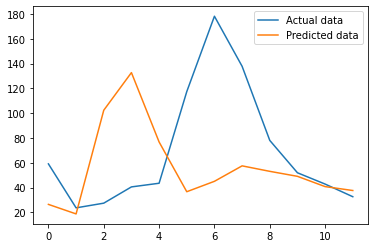

In [0]:
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(test_data_pr['y'].values, label="Actual data")
ax.plot(prophet_pred['Pred'].values, label="Predicted data")
ax.legend()

f.show()

In [0]:
test_data_pr

,ds,y
194,2019-07-08,59.139912
195,2019-07-22,23.713952
196,2019-08-08,27.493029
197,2019-08-22,40.592917
198,2019-09-08,43.538575
199,2019-09-22,117.365370
200,2019-10-08,178.115364
201,2019-10-22,137.775549
202,2019-11-08,78.064415
203,2019-11-22,51.986095
